In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

In [2]:
# Use a built-in style. Other options include 'bmh', 'fivethirtyeight', 'classic', etc.
plt.style.use('ggplot')

# Global settings for consistent styling across plots
plt.rcParams.update({
    # Figure settings
    'figure.figsize': (10, 6),    # Width, height in inches
    'figure.dpi': 100,            # Resolution of the figure
    # Font settings
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 12,
    # Axes settings
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.grid': True,            # Enable grid on axes
    # Grid line style
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    # Line settings
    'lines.linewidth': 2,
    'lines.markersize': 6,
    # Tick settings
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    # Legend settings
    'legend.fontsize': 10,
    'legend.frameon': True,
})

In [3]:
def vasicek_simulation(a, b, sigma, r0, T, num_tsteps, num_paths):
  """
  Similation of the Vasicek interest rate model using the Euler-Maruyama method.

  Parameters
  ----------
  a: float
    Speed of mean reversion
  b: float
    Long-term mean interest rate
  sigma: float
    Volatility of interest rate
  r0: float
    Initial interest rate
  T: float
    Time horizon
  num_tsteps: int
    Number of time steps
  num_paths: int
    Number of paths to simulate

  Returns
  -------
  numpy.ndarray
    The array of simulated interest rates over time
  """

  dt = T / num_tsteps

  vasicek_rates = np.zeros((int(num_tsteps) + 1, num_paths))
  vasicek_rates[0] = r0 # Assign zeroth row with values r0

  for t in range(1, int(num_tsteps) + 1):
    vasicek_rates[t] = vasicek_rates[t - 1] + a * (b - vasicek_rates[t - 1]) * dt + sigma * np.sqrt(dt) * np.random.randn(num_paths)

  return vasicek_rates

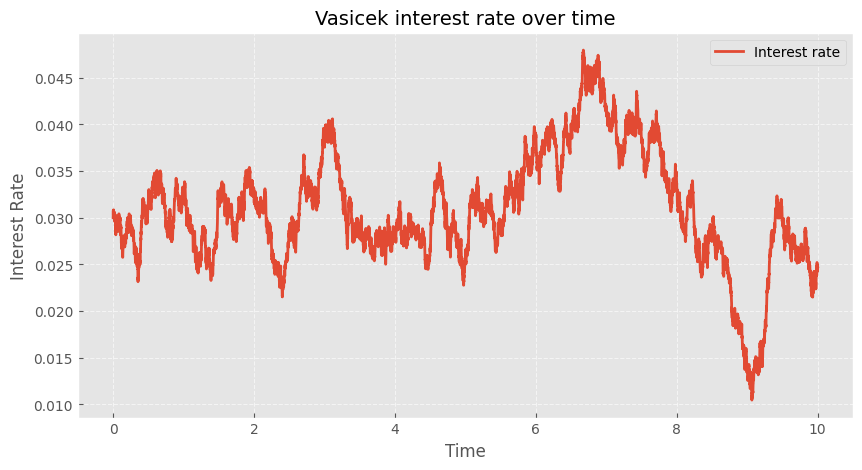

In [4]:
T = 10 # Time horizon (10 years)
num_tsteps = 1e4 # Number of time steps
a = 0.5 # Speed of mean reversion
b = 0.03 # Long-term mean interest rate
sigma = 0.01 # Volatility of interest rate
r0 = 0.03 # Initial interest rate

# Calculating rates for a single path
v_rates1 = vasicek_simulation(a, b, sigma, r0, T, num_tsteps, 1)

# Plotting the result
dt_points = np.linspace(0, T, int(num_tsteps) + 1)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dt_points, v_rates1, label='Interest rate')
ax.set_xlabel('Time')
ax.set_ylabel('Interest Rate')
ax.set_title('Vasicek interest rate over time')
ax.legend()

In [5]:
v_rates1.shape

(10001, 1)

In [6]:
def vasicek_MLE(r, T, num_tsteps):
  """
  Determines the parameters of the Vasicek model using maximum likelihood estimation.

  Parameters
  ----------
  r: numpy.ndarray
    One-dimensional interest rate data
  T: int
    Time horizon
  num_tsteps: int
    Number of time steps

  Returns
  -------
  numpy.ndarray
    The array of calibrated parameters [a, b, sigma]
  """

  dt = T / num_tsteps # Time step size
  n = len(r) - 1

  S0 = 0
  S1 = 0
  S00 = 0
  S01 = 0

  # Estimation of a and b parameters from MLE
  for i in range(1, n + 1):
    S0 += r[i-1]
    S1 += r[i]
    S00 += r[i-1] ** 2
    S01 += r[i-1] * r[i]
  S0 = S0 / n
  S1 = S1 / n
  S00 = S00 / n
  S01 = S01 / n

  b_MLE = (S1 * S00 - S0 * S01) / (S0 * S1 - S0 ** 2 - S01 + S00)
  a_MLE = (1 / dt) * np.log((S0 - b_MLE) / (S1 - b_MLE))

  # Estimation of sigma
  beta = (1 / a_MLE) * (1 - np.exp(- a_MLE * dt))
  summand = 0
  for i in range(1, n + 1):
    m_t = b_MLE * a_MLE * beta + r[i - 1] * (1 - a_MLE * beta)
    summand += (r[i] - m_t) ** 2

  sigma_MLE = ((1 / (n * beta * (1 - 0.5 * a_MLE * beta))) * summand) ** 0.5

  return np.concatenate([a_MLE, b_MLE, sigma_MLE])

In [7]:
estimates_MLE = vasicek_MLE(v_rates1, 10, 1e2).round(3)
print("{:<17}: {:8.3f}".format("estimate of a", estimates_MLE[0]))
print("{:<17}: {:8.3f}".format("estimate of b", estimates_MLE[1]))
print("{:<17}: {:8.3f}".format("estimate of sigma", estimates_MLE[2]))

estimate of a    :    0.013
estimate of b    :    0.030
estimate of sigma:    0.001


In [8]:
from sklearn.linear_model import LinearRegression

def vasicek_LS(r, T, num_tsteps):

  dt = T / num_tsteps

  # Linear regression
  r0 = r[:-1,]
  r1 = r[1:,0]
  reg = LinearRegression().fit(r0, r1)

  # Estimation a and b
  a_LS = ( 1 - reg.coef_) / dt
  b_LS = reg.intercept_ / (dt * a_LS)

  # Estimation sigma
  epsilon = r[1:,0] - r[:-1,0] * reg.coef_
  sigma_LS = np.std(epsilon) / (dt ** 0.5)

  return a_LS[0], b_LS[0], sigma_LS

In [9]:
estimates_LS = vasicek_LS(v_rates1, 10, 1e2)
print("{:<17}: {:8.3f}".format("estimate of a", estimates_LS[0].round(3)))
print("{:<17}: {:8.3f}".format("estimate of b", estimates_LS[1].round(3)))
print("{:<17}: {:8.3f}".format("estimate of sigma", estimates_LS[2].round(3)))

estimate of a    :    0.013
estimate of b    :    0.030
estimate of sigma:    0.001


In [10]:
v_rates1[:-1,].shape, v_rates1[1:,0].shape # ((n_samples, n_features), (n_samples, n_targets)

((10000, 1), (10000,))

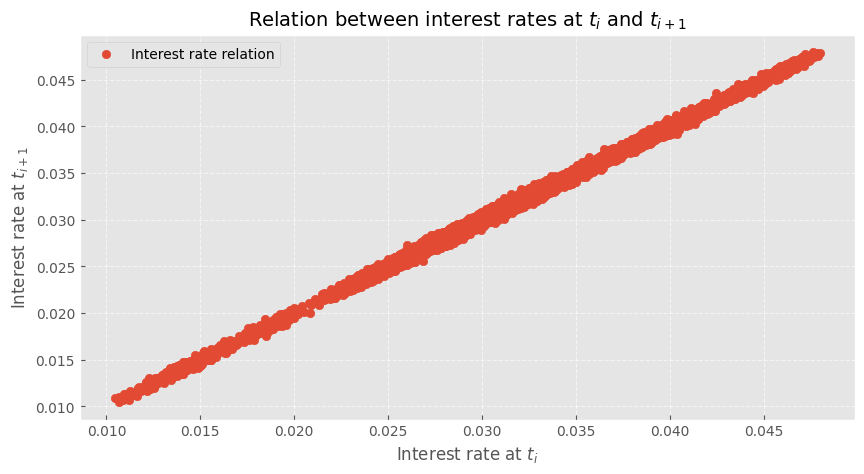

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(v_rates1[:-1,], v_rates1[1:,0], label='Interest rate relation')
ax.set_xlabel('Interest rate at $t_{i}$')
ax.set_ylabel('Interest rate at $t_{i+1}$')
ax.set_title('Relation between interest rates at $t_i$ and $t_{i+1}$')
ax.legend()

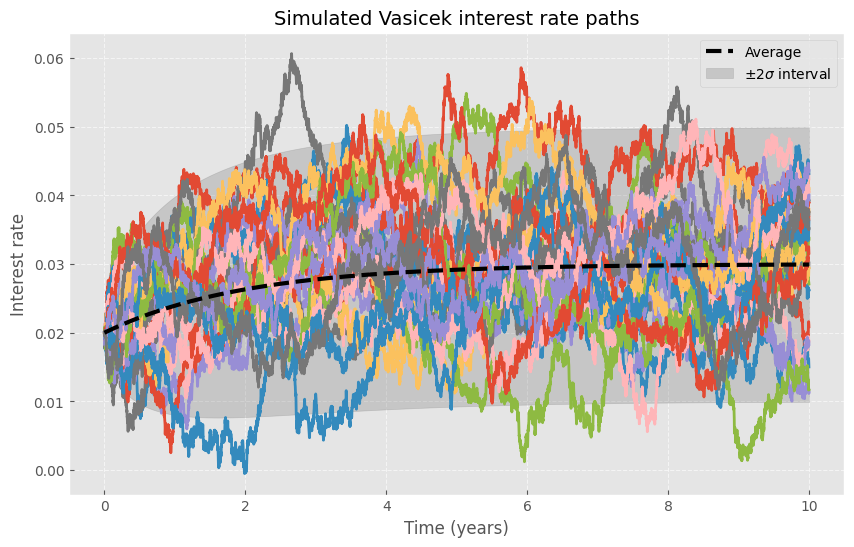

In [12]:
# Parameters
a = 0.5 # Speed of mean reversion
b = 0.03 # Long-term mean
sigma = 0.01 # Volatility
r0 = 0.02 # Initial interest rate
T = 10 # Time horizon
num_tsteps = 1e4 # Number of time steps
num_paths = 25 # Number of paths

# Similating Vasicek paths
vasicek_paths = vasicek_simulation(a, b, sigma, r0, T, num_tsteps, num_paths)

dt_points = np.linspace(0, T, int(num_tsteps) + 1)

# Plotting Vasicek paths
fig, ax = plt.subplots()
for i in range(num_paths):
  ax.plot(dt_points, vasicek_paths[:,i])

# Average rate
average_rate = r0 * np.exp(- a * dt_points) + b * (1 - np.exp(- a * dt_points))
ax.plot(dt_points, average_rate, color='black', linestyle='--', linewidth=3, label='Average')

# Sds +2/-2 std bounds
std = ((sigma ** 2 / (2 * a))* (1 - np.exp(- 2 * a * dt_points))) ** 0.5
upper_bound = average_rate + 2 * std
lower_bound = average_rate - 2 * std
ax.fill_between(dt_points, upper_bound, lower_bound, color='gray', alpha=0.3, label='$\pm 2\sigma$ interval')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Interest rate')
ax.set_title('Simulated Vasicek interest rate paths')
ax.legend()

In [13]:
%%time
# Parameters
a = 0.5 # Speed of mean reversion
b = 0.03 # Long-term mean
sigma = 0.01 # Volatility
r0 = 0.02 # Initial interest rate
T = 10 # Time horizon
num_tsteps = 2520 # Number of time steps
num_paths = 100 # Number of paths

a_estimates_LS = []
b_estimates_LS = []
sigma_estimates_LS = []
a_estimates_MLE = []
b_estimates_MLE = []
sigma_estimates_MLE = []


for i in range(num_paths):
  vasicek_path = vasicek_simulation(a, b, sigma, r0, T, num_tsteps, 1)
  estimates_LS = vasicek_LS(vasicek_path, T, num_tsteps)
  estimates_MLE = vasicek_MLE(vasicek_path, T, num_tsteps)
  a_estimates_LS.append(estimates_LS[0])
  b_estimates_LS.append(estimates_LS[1])
  sigma_estimates_LS.append(estimates_LS[2])
  a_estimates_MLE.append(estimates_MLE[0])
  b_estimates_MLE.append(estimates_MLE[1])
  sigma_estimates_MLE.append(estimates_MLE[2])
a_estimates_LS = np.array(a_estimates_LS)
b_estimates_LS = np.array(b_estimates_LS)
sigma_estimates_LS = np.array(sigma_estimates_LS)
a_estimates_MLE = np.array(a_estimates_MLE)
b_estimates_MLE = np.array(b_estimates_MLE)
sigma_estimates_MLE = np.array(sigma_estimates_MLE)

CPU times: user 7.95 s, sys: 203 ms, total: 8.15 s
Wall time: 8.13 s


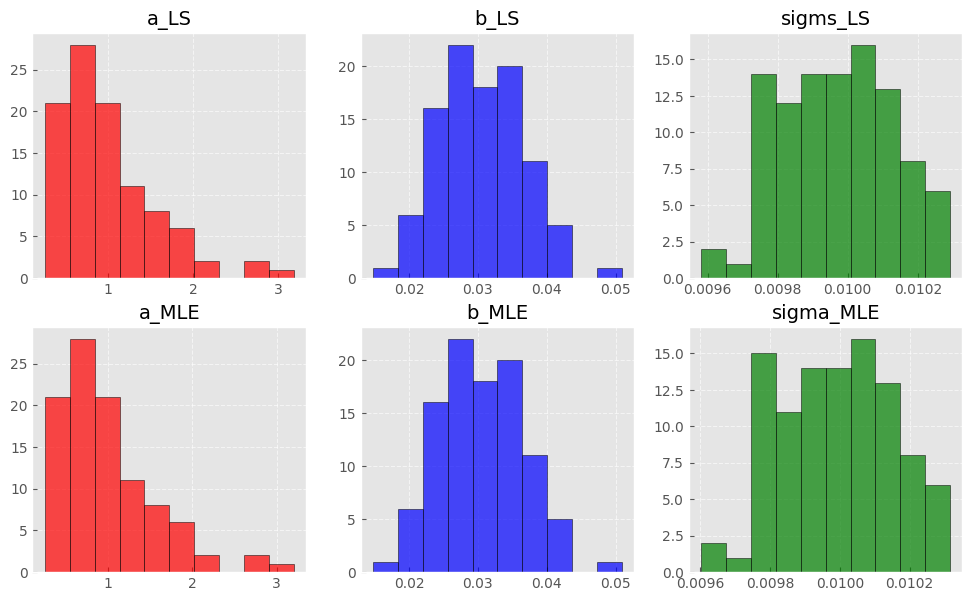

In [14]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7))
ax[0,0].hist(a_estimates_LS, bins=10, color='red', edgecolor='black', alpha=0.7)
ax[0,0].set_title('a_LS')
ax[0,1].hist(b_estimates_LS, bins=10, color='blue', edgecolor='black', alpha=0.7)
ax[0,1].set_title('b_LS')
ax[0,2].hist(sigma_estimates_LS, bins=10, color='green', edgecolor='black', alpha=0.7)
ax[0,2].set_title('sigms_LS')
ax[1,0].hist(a_estimates_MLE, bins=10, color='red', edgecolor='black', alpha=0.7)
ax[1,0].set_title('a_MLE')
ax[1,1].hist(b_estimates_MLE, bins=10, color='blue', edgecolor='black', alpha=0.7)
ax[1,1].set_title('b_MLE')
ax[1,2].hist(sigma_estimates_MLE, bins=10, color='green', edgecolor='black', alpha=0.7)
ax[1,2].set_title('sigma_MLE')
plt.show()

Note that the speed of mean reversion (denoted by a above) is very difficult to estimate, while the long-term mean (b) and the volatility ($\sigma$) are stable.

# Real-world data from US Treasury rates

In [15]:
df_original = pd.read_csv('daily-trasuryrates_2023-2024_252.csv')
df0 = df_original.copy()

In [16]:
df0 = df0[['Date', '3 Mo']]

In [17]:
df1 = df0.copy()

In [18]:
df1['3 Mo'] = df1['3 Mo']/100

In [19]:
rates252_US = np.array(df1['3 Mo'])
rates252_US

array([0.055 , 0.055 , 0.0546, 0.0544, 0.0542, 0.0538, 0.0537, 0.054 ,
       0.0536, 0.0536, 0.0533, 0.0534, 0.0539, 0.054 , 0.054 , 0.0541,
       0.055 , 0.0544, 0.0544, 0.0546, 0.0543, 0.0544, 0.0544, 0.0546,
       0.0546, 0.0548, 0.0549, 0.0547, 0.0547, 0.0549, 0.0549, 0.0549,
       0.0549, 0.0549, 0.055 , 0.0551, 0.0551, 0.0551, 0.0551, 0.0552,
       0.0555, 0.0554, 0.0553, 0.0554, 0.0554, 0.0556, 0.0557, 0.0555,
       0.0554, 0.0554, 0.0556, 0.0556, 0.0556, 0.0556, 0.0555, 0.0557,
       0.0557, 0.0557, 0.0558, 0.0561, 0.0558, 0.0556, 0.0556, 0.0556,
       0.0553, 0.0555, 0.0555, 0.0553, 0.0555, 0.0555, 0.0556, 0.0555,
       0.0555, 0.0556, 0.0555, 0.0554, 0.0556, 0.0557, 0.0556, 0.0558,
       0.0558, 0.0558, 0.0556, 0.0555, 0.0562, 0.0562, 0.0561, 0.0561,
       0.0563, 0.0561, 0.0561, 0.0563, 0.0562, 0.0561, 0.0562, 0.0561,
       0.056 , 0.0558, 0.0558, 0.0558, 0.0559, 0.0559, 0.0559, 0.056 ,
       0.0559, 0.0557, 0.0554, 0.0553, 0.0556, 0.0555, 0.0554, 0.0554,
      

In [20]:
rates252_US.shape

(252,)

In [21]:
rates252_US[0]

0.055

In [73]:
r = rates252_US.reshape((252, 1))
T = 1 # 1 year
num_steps = 252 # Trading days in a year

estimatesUS_MLE = vasicek_MLE(r, T, num_steps)
print("{:<17}: {:8.3f}".format("estimate of a", estimatesUS_MLE[0].round(3)))
print("{:<17}: {:8.3f}".format("estimate of b", estimatesUS_MLE[1].round(3)))
print("{:<17}: {:8.3f}".format("estimate of sigma", estimatesUS_MLE[2].round(3)))

estimate of a    :   11.329
estimate of b    :    0.055
estimate of sigma:    0.003


In [74]:
estimatesUS_LS = vasicek_LS(r, T, num_steps)
print("{:<17}: {:8.3f}".format("estimate of a", estimatesUS_LS[0].round(3)))
print("{:<17}: {:8.3f}".format("estimate of b", estimatesUS_LS[1].round(3)))
print("{:<17}: {:8.3f}".format("estimate of sigma", estimatesUS_LS[2].round(3)))

estimate of a    :   11.079
estimate of b    :    0.055
estimate of sigma:    0.003


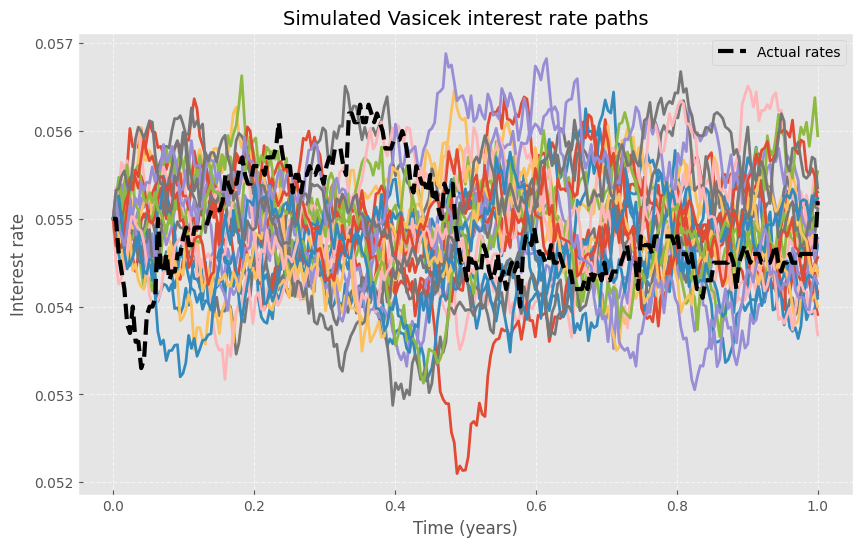

In [24]:
# Parameters
a = estimatesUS_MLE[0] # Speed of mean reversion
b = estimatesUS_MLE[1] # Long-term mean
sigma = estimatesUS_MLE[2] # Volatility
r0 = rates252_US[0] # Initial interest rate
T = 1 # Time horizon
num_tsteps = 252 # Number of time steps
num_paths = 25 # Number of paths

# Similating Vasicek paths
vasicek_paths = vasicek_simulation(a, b, sigma, r0, T, num_tsteps, num_paths)

dt_points = np.linspace(0, T, int(num_tsteps) + 1)

# Plotting Vasicek paths
fig, ax = plt.subplots()
for i in range(num_paths):
  ax.plot(dt_points, vasicek_paths[:,i])

# Note len(rates252_US) = len(vasicek_paths) - 1
ax.plot(np.linspace(0, T, int(num_tsteps)), rates252_US, color='black', linestyle='--', linewidth=3, label='Actual rates')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Interest rate')
ax.set_title('Simulated Vasicek interest rate paths')
ax.legend()

Let us forecast the yield curve with the calibrated parameters and compare it with real data from 03.06.2025 -- 07.03.2025.

In [49]:
df1 = pd.read_csv('/content/daily-treasury-rates-2024.csv')
df2 = pd.read_csv('/content/daily-treasury-rates-2025.csv')

In [50]:
df1 = df1[::-1]
df2 = df2[::-1]

In [51]:
df2.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)

In [52]:
df2[['Date', '3 Mo']].head()

,Date,3 Mo
0,01/02/2025,4.36
1,01/03/2025,4.34
2,01/06/2025,4.35
3,01/07/2025,4.35
4,01/08/2025,4.35


In [45]:
df1[['Date', '3 Mo']].tail()

,Date,3 Mo
245,12/24/2024,4.40
246,12/26/2024,4.35
247,12/27/2024,4.31
248,12/30/2024,4.37
249,12/31/2024,4.37


In [53]:
df3 = pd.concat([df1, df2], axis=0, ignore_index=True)

In [57]:
df1.shape

(250, 14)

In [58]:
df2.shape

(45, 15)

In [56]:
df3.shape

(295, 15)

In [60]:
df3 = df3[['Date', '3 Mo']]

In [63]:
df3.iloc[105:]

,Date,3 Mo
105,06/03/2024,5.52
106,06/04/2024,5.52
107,06/05/2024,5.51
108,06/06/2024,5.51
109,06/07/2024,5.52
...,...,...
290,03/03/2025,4.35
291,03/04/2025,4.34
292,03/05/2025,4.35
293,03/06/2025,4.34


In [69]:
ratesUS_forward = np.array(((df3['3 Mo'].iloc[105:])/100))
ratesUS_forward.shape

(190,)

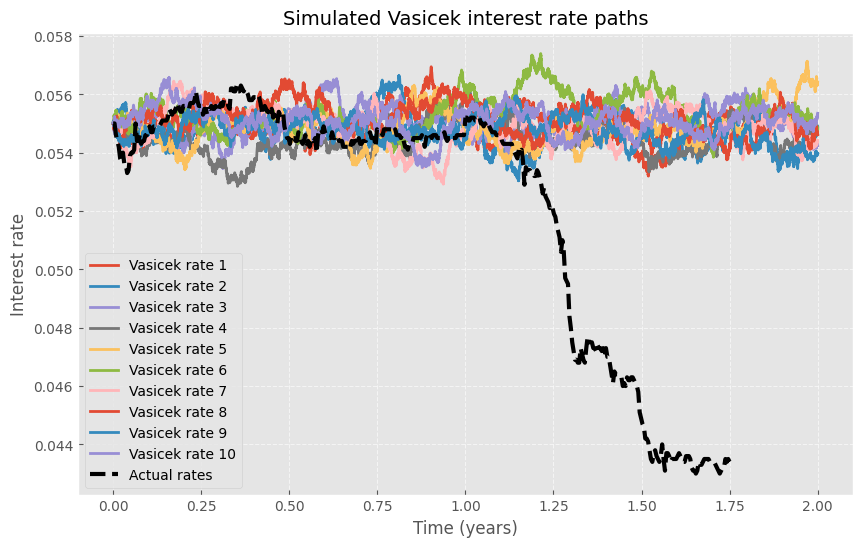

In [83]:
# Parameters
a = estimatesUS_MLE[0] # Speed of mean reversion
b = estimatesUS_MLE[1] # Long-term mean
sigma = estimatesUS_MLE[2] # Volatility
r0 = rates252_US[0] # Initial interest rate
T = 2 # Time horizon
num_tsteps = 10000 # Number of time steps
num_paths = 10 # Number of paths

# Similating Vasicek paths
vasicek_paths = vasicek_simulation(a, b, sigma, r0, T, num_tsteps, num_paths)

dt_points = np.linspace(0, T, int(num_tsteps) + 1)

# Plotting Vasicek paths
fig, ax = plt.subplots()
for i in range(num_paths):
  ax.plot(dt_points, vasicek_paths[:,i], label='Vasicek rate {}'.format(i + 1))

# Actual rates
dt_points2 = np.linspace(0, T/2, 252)
dt_points3 = np.linspace(T/2, 1 + 190 / 252, 190)
ax.plot(dt_points2, rates252_US, color='black', linestyle='--', linewidth=3, label='Actual rates')
ax.plot(dt_points3, ratesUS_forward, color='black', linestyle='--', linewidth=3)


ax.set_xlabel('Time (years)')
ax.set_ylabel('Interest rate')
ax.set_title('Simulated Vasicek interest rate paths')
ax.legend()

The Vasicek model parameters of the plot above were determined from the data between time $t \in [0,1]$. The black line in the plot indicates the data from the real-world US Treasury rates.

One can see that for the time $t > 1$, or the test region, the model did a poor job predict the future 3 month yield curve rates.